<a href="https://colab.research.google.com/github/Keetawin/RoBERTaEmojiSentimentAnalysis/blob/main/RoBERTa_EmojiSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required Library

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import _utils as fn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import set_seed
import torch
import transformers
from transformers import BertTokenizer, BertModel,AutoTokenizer, AutoModelForMaskedLM,AutoModelForSequenceClassification,get_linear_schedule_with_warmup
from torch import nn
from torch.utils.data import Dataset, DataLoader
import tqdm


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Import Data & Analyse distribution

In [ ]:
df = pd.read_csv('emoji_data.csv')


In [ ]:
df.head()

,sentence,emoji
0,"During the period of falling in love, each tim...",0
1,When I was involved in a traffic accident.,1
2,When I was driving home after several days of...,2
3,When I lost the person who meant the most to me.,3
4,The time I knocked a deer down - the sight of ...,4


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129326 (\N{FACE WITH OPEN MOUTH VOMITING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


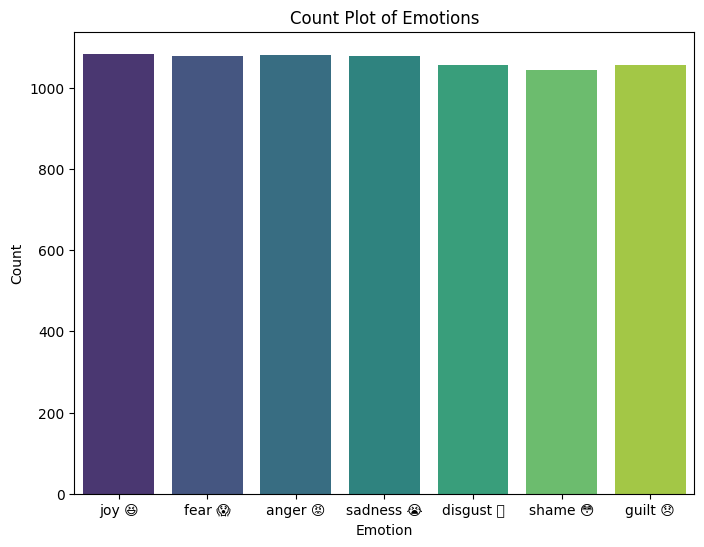

In [ ]:

emoji_to_emotion = {
  0: 'joy 😆',
    1: 'fear 😱',
    2: 'anger 😡',
    3: 'sadness 😭',
    4: 'disgust 🤮',
    5: 'shame 😳',
    6: 'guilt 😞'
}

# Map emotions to DataFrame
df['emotion'] = df['emoji'].map(emoji_to_emotion)

# Plot count plot
plt.figure(figsize=(8, 6))
sns.countplot(x='emotion', data=df, palette='viridis')
plt.title('Count Plot of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

see how the RoBERTa tokenizer converts sentences into token ids.

In [ ]:
from transformers import AutoTokenizer

bert_model_name = 'SamLowe/roberta-base-go_emotions'
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

sample_text = df.sentence[0]
tokens = tokenizer.tokenize(sample_text)
ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'{sample_text}')
print('-'*60)
print(tokens)
print('-'*60)
print(ids)


During the period of falling in love, each time that we met and especially when we had not met for a long time.
------------------------------------------------------------
['During', 'Ġthe', 'Ġperiod', 'Ġof', 'Ġfalling', 'Ġin', 'Ġlove', ',', 'Ġeach', 'Ġtime', 'Ġthat', 'Ġwe', 'Ġmet', 'Ġand', 'Ġespecially', 'Ġwhen', 'Ġwe', 'Ġhad', 'Ġnot', 'Ġmet', 'Ġfor', 'Ġa', 'Ġlong', 'Ġtime', '.']
------------------------------------------------------------
[14229, 5, 675, 9, 3064, 11, 657, 6, 349, 86, 14, 52, 1145, 8, 941, 77, 52, 56, 45, 1145, 13, 10, 251, 86, 4]


# Distribution max length of sequence

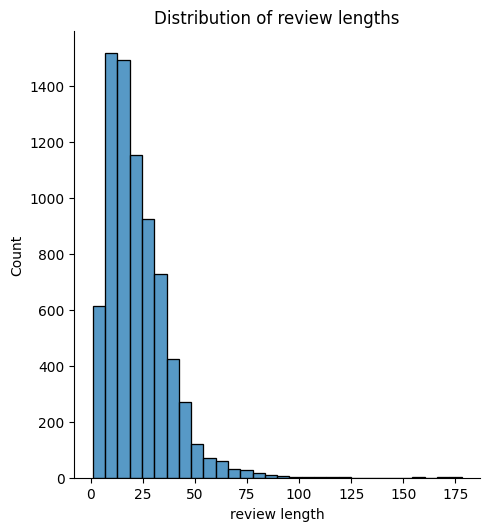

In [ ]:
lengths = np.array([len(x.split()) for x in df.sentence])
sns.displot(lengths, kde=False, bins=30)
plt.xlabel('review length')
plt.title('Distribution of review lengths')
plt.show()

optimal max len = 100 will be fine

# Training, Test, Validation Data split

In [ ]:
# Split train & test sets
df_train,df_test= train_test_split(df,test_size =0.2, random_state=RANDOM_SEED, shuffle = True)
# Split train validate sets
df_train,df_val= train_test_split(df_train,test_size=0.1, random_state=RANDOM_SEED, shuffle = True)
print(df_train.shape , df_test.shape , df_val.shape)

(5385, 3) (1496, 3) (599, 3)


# Dataloader

In [ ]:
class Encode(Dataset):
    def __init__(self, sentence, emoji, tokenizer, max_len, num_classes):
        self.sentence = sentence
        self.emoji = emoji
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.num_classes = num_classes  # จำนวนคลาส

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, index):
        sentence = self.sentence[index]
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        emoji_one_hot = torch.eye(self.num_classes)[self.emoji[index]]

        return {
            'sentence': sentence,
            'input_id': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emoji': emoji_one_hot
        }


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
MAX_LEN = 100

training_data = Encode(sentence = df_train.sentence.to_numpy(),
                               emoji = df_train.emoji.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN,num_classes=7)

validation_data = Encode(sentence = df_val.sentence.to_numpy(),
                               emoji = df_val.emoji.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN,num_classes=7)

test_data = Encode(sentence = df_test.sentence.to_numpy(),
                               emoji = df_test.emoji.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN,num_classes=7)

In [ ]:
print(len(training_data),len(test_data),len(validation_data))

5385 1496 599


In [ ]:
## DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

In [ ]:
sample_batch = next(iter(train_loader))
sample_batch.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['sentence', 'input_id', 'attention_mask', 'emoji'])

In [ ]:
print(sample_batch['sentence'][1])
print(sample_batch['input_id'][1])
print(sample_batch['attention_mask'][1])
print(sample_batch['emoji'][1])
print('-'*60)
print(sample_batch['input_id'].shape,sample_batch['attention_mask'].shape,sample_batch['emoji'].shape)

When I talk to my friends.
tensor([   0, 1779,   38, 1067,    7,  127,  964,    4,    2,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# RoBERTa-base model

set lable and change dropout to 0.4

In [ ]:
class SentimentAnalysisModel(torch.nn.Module):
    def __init__(self, bert_model_name, num_labels=7, dropout_rate=0.4):
        super(SentimentAnalysisModel, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)
        self.model.classifier.out_proj = torch.nn.Linear(self.model.config.hidden_size, num_labels)
        self.model.classifier.dropout = torch.nn.Dropout(p=dropout_rate, inplace=False)
        # ปรับ dropout ในทุก RobertaLayer
        for layer in self.model.roberta.encoder.layer:
            layer.attention.self.dropout = torch.nn.Dropout(p=dropout_rate)
            layer.attention.output.dropout = torch.nn.Dropout(p=dropout_rate)
            layer.intermediate.dropout = torch.nn.Dropout(p=dropout_rate)
            layer.output.dropout = torch.nn.Dropout(p=dropout_rate)

        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
        return outputs

    def predict_sentiment(self, text):
        # ทำการ tokenize ข้อความ
        inputs = self.tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        # นำข้อมูลเข้าโมเดลเพื่อทำนาย
        outputs = self.forward(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # ทำ softmax เพื่อหาความน่าจะเป็น
        predicted_prob = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(predicted_prob, dim=1).item()
        predicted_emotion = emoji_to_emotion[predicted_class]

        return predicted_prob, predicted_emotion


In [ ]:
model = SentimentAnalysisModel(bert_model_name, num_labels=7, dropout_rate=0.4).to(device)
model

SentimentAnalysisModel(
  (model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.4, inplace=False)
              )
              (output): RobertaSelfOutput(
                

# Fine-Tuning

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        input_ids = batch["input_id"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["emoji"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # แก้ไขนี้: เพิ่มการคำนวณ accuracy
        predicted = torch.argmax(outputs.logits, dim=1)
        total_correct += (predicted == labels.argmax(dim=1)).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples  # คำนวณ accuracy
    return average_loss, accuracy


In [ ]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_id'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['emoji'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            predicted = torch.argmax(outputs.logits, dim=1)

            total_loss += loss.item()
            total_correct += (predicted == labels.argmax(dim=1)).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(val_loader)
    accuracy = total_correct / total_samples

    return average_loss, accuracy


In [ ]:
import torch
import pickle

# define hyperparameters
EPOCHS = 20

# Initialize Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss()

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps, last_epoch=-1)

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

best_val_accuracy = 0.0

for epoch in range(EPOCHS):
    # Training
    train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy * 100:.2f}%")

    # Validation
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    scheduler.step()

    # history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    # save checkpoint when val_accuracy better
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'val_loss': val_loss,
            'accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        }
        torch.save(checkpoint, f"best_model_{val_accuracy:.2f}.pth")

with open('history.pkl', 'wb') as f:
    pickle.dump(history, f)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/20, Training Loss: 0.4626597109630968, Training Accuracy: 14.89%
Epoch 1/20, Validation Loss: 0.4288399768503089, Validation Accuracy: 18.36%
Epoch 2/20, Training Loss: 0.4155392673241316, Training Accuracy: 15.12%
Epoch 2/20, Validation Loss: 0.4159810590116601, Validation Accuracy: 27.05%
Epoch 3/20, Training Loss: 0.4021904269266411, Training Accuracy: 24.33%
Epoch 3/20, Validation Loss: 0.38402129631293447, Validation Accuracy: 45.91%
Epoch 4/20, Training Loss: 0.36182695080542704, Training Accuracy: 41.84%
Epoch 4/20, Validation Loss: 0.3091298702516054, Validation Accuracy: 58.93%
Epoch 5/20, Training Loss: 0.3240640792973648, Training Accuracy: 50.97%
Epoch 5/20, Validation Loss: 0.27906138881256703, Validation Accuracy: 61.44%
Epoch 6/20, Training Loss: 0.30052612554392166, Training Accuracy: 55.13%
Epoch 6/20, Validation Loss: 0.2548267339405261, Validation Accuracy: 64.27%
Epoch 7/20, Training Loss: 0.28301420649127845, Training Accuracy: 58.76%
Epoch 7/20, Validation

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # พล็อตกราฟ Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # พล็อตกราฟ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



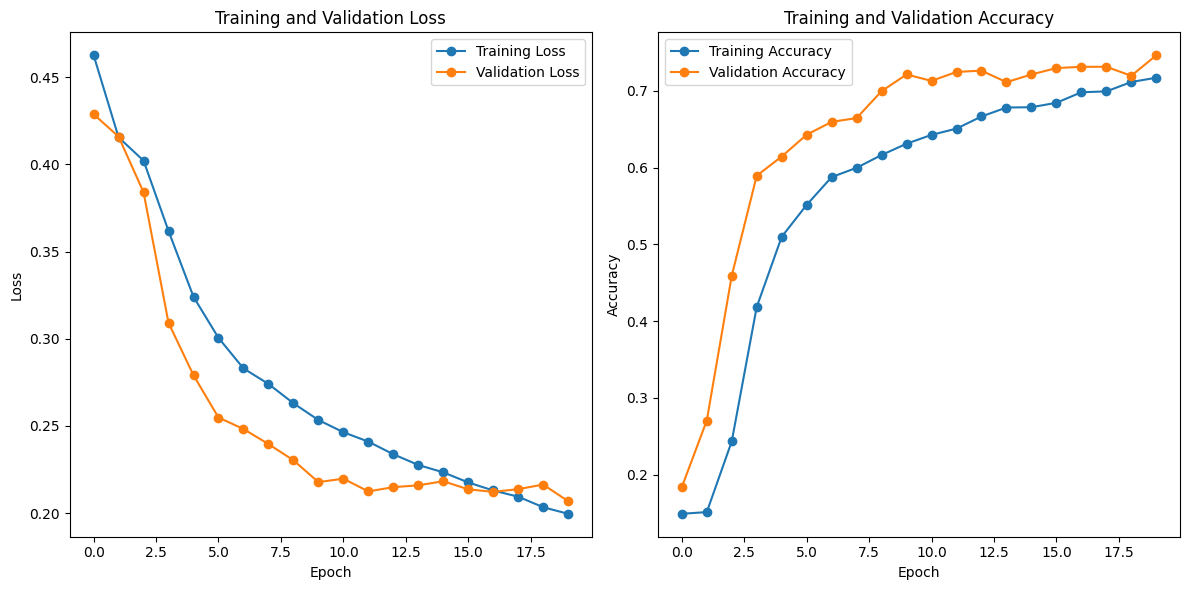

In [ ]:
plot_history(history)

# Evaluation model on Test data

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in tqdm(data_loader):

            texts = d["sentence"]
            input_ids = d["input_id"]
            attention_mask = d["attention_mask"]
            targets = d["emoji"]

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            logits = outputs.logits  # Assuming logits attribute contains the predicted scores

            _, preds = torch.max(logits, dim=1)

            probs = F.softmax(logits, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(torch.argmax(targets, dim=1))  # Convert one-hot to labels

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)

  0%|          | 0/47 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 47/47 [01:42<00:00,  2.18s/it]


## Classification Report

In [ ]:
class_names =   ['😆','😱','😡','😭','🤮','😳','😞']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           😆       0.88      0.94      0.91       229
           😱       0.79      0.76      0.77       217
           😡       0.63      0.63      0.63       223
           😭       0.71      0.75      0.73       224
           🤮       0.72      0.70      0.71       200
           😳       0.56      0.63      0.59       195
           😞       0.74      0.60      0.66       208

    accuracy                           0.72      1496
   macro avg       0.72      0.72      0.72      1496
weighted avg       0.72      0.72      0.72      1496



## Input Text

In [ ]:
model.to("cpu")
text_to_predict = "i love you so much"

text_to_predict = [text_to_predict]
predicted_class = model.predict_sentiment(text_to_predict)

print(f"Predicted Class: {predicted_class[1]}")


Predicted Class: joy 😆


In [ ]:
text_to_predict = "I will kill you"

text_to_predict = [text_to_predict]
predicted_class = model.predict_sentiment(text_to_predict)

print(f"Predicted Class: {predicted_class[1]}")

Predicted Class: fear 😱


In [ ]:
torch.save(model.state_dict(), "best_model_75.pth")

# Write Gradio Deployment File

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
sentiment_demo_path = Path("demos/sentiment/")

# Remove files that might already exist there and create new directory
if sentiment_demo_path.exists():
    shutil.rmtree(sentiment_demo_path)
    sentiment_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    sentiment_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/sentiment/

In [ ]:
%%writefile demos/sentiment/model.py

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

class SentimentAnalysisModel(torch.nn.Module):
    def __init__(self, bert_model_name, num_labels=7, dropout_rate=0.4):
        super(SentimentAnalysisModel, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)
        self.model.classifier.out_proj = torch.nn.Linear(self.model.config.hidden_size, num_labels)
        self.model.classifier.dropout = torch.nn.Dropout(p=dropout_rate, inplace=False)
        # ปรับ dropout ในทุก RobertaLayer
        for layer in self.model.roberta.encoder.layer:
            layer.attention.self.dropout = torch.nn.Dropout(p=dropout_rate)
            layer.attention.output.dropout = torch.nn.Dropout(p=dropout_rate)
            layer.intermediate.dropout = torch.nn.Dropout(p=dropout_rate)
            layer.output.dropout = torch.nn.Dropout(p=dropout_rate)

        self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
        return outputs


Writing demos/sentiment/model.py


In [ ]:
%%writefile demos/sentiment/app.py

import torch
import gradio as gr
from model import SentimentAnalysisModel
from timeit import default_timer as timer

# Load the pre-trained sentiment analysis model
model = SentimentAnalysisModel(bert_model_name="SamLowe/roberta-base-go_emotions", num_labels=7)
model.load_state_dict(torch.load("best_model_75.pth", map_location=torch.device('cpu')), strict=False)

model.eval()

# Mapping from predicted class to emoji
emoji_to_emotion = {
    0: 'joy 😆',
    1: 'fear 😱',
    2: 'anger 😡',
    3: 'sadness 😭',
    4: 'disgust 🤮',
    5: 'shame 😳',
    6: 'guilt 😞'
}

# Function to make predictions
def predict_sentiment(text):
    start_time = timer()

    inputs = model.tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Map predicted class to emoji
    predicted_class = torch.argmax(logits, dim=1).item()
    result = emoji_to_emotion[predicted_class]

    # Create a dictionary of class probabilities
    class_probabilities = {emoji_to_emotion[i]: float(probabilities[0, i]) for i in range(len(emoji_to_emotion))}

    # Calculate prediction time
    pred_time = round(timer() - start_time, 5)

    return class_probabilities, pred_time

# Create title, description and article strings
title = "Emoji-aware Sentiment Analysis using Roberta Model"
description = "Explore the power of sentiment analysis with our Emotion Detector! Simply input a sentence or text, and let our model predict the underlying emotion."
article = "Sentiment Analysis, also known as opinion mining, is a branch of Natural Language Processing (NLP) that involves determining the emotional tone behind a piece of text. This powerful tool allows us to uncover the underlying feelings, attitudes, and opinions expressed in written communication."


# Interface for Gradio
iface = gr.Interface(
    fn=predict_sentiment,
    inputs="text",
    outputs=[gr.Label(num_top_classes=7, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
    title=title,
    description=description,
    article=article)

# Launch the Gradio interface
iface.launch()



Writing demos/sentiment/app.py


In [ ]:
%%writefile demos/sentiment/requirements.txt
torch
transformers
gradio

Writing demos/sentiment/requirements.txt


In [ ]:
!ls demos/sentiment

app.py	best_model_75.pth  model.py  requirements.txt


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/sentiment && zip -r ../sentiment.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 51%)
  adding: best_model_75.pth (deflated 24%)
  adding: model.py (deflated 62%)
  adding: requirements.txt (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp demos/sentiment.zip "/content/drive/MyDrive/model/"